In [1]:
import pickle
import numpy as np
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
methods = ["Difference", "IG", "IH", "Mahe", "SI", "STI", "SCD", "SOC", "ArchAttribute"]
pcts = [0.1,0.2,0.3,0.4,0.5]
save_tag = "6-1"

result_paths = {}
result_paths["Difference"] = ['results/word_corr_difference.pickle', 'results/phrase_corr_difference.pickle']
result_paths["IG"] = ['results/word_corr_ig.pickle','results/phrase_corr_ig.pickle']
result_paths["IH"] = [None, 'results/phrase_corr_ih.pickle']
result_paths["Mahe"] = [ "results/word_corr_mahe.pickle", "results/phrase_corr_mahe.pickle"]
result_paths["SI"] = ['results/word_corr_si.pickle', 'results/phrase_corr_si.pickle']
result_paths["STI"]  = ['results/word_corr_sti.pickle', 'results/phrase_corr_sti.pickle']
result_paths["SCD"] = [ 'results/word_corr_scd.pickle',  'results/phrase_corr_scd.pickle']
result_paths["SOC"] = ['results/word_corr_soc.pickle', 'results/phrase_corr_soc.pickle', ]
result_paths["ArchAttribute"] = ['results/word_corr_archattribute.pickle', 'results/phrase_corr_archattribute.pickle']

In [3]:
exp_corrs = {}
for exp_i, exp in enumerate(["word $\rho$", "phrase $\rho$"]):    
    method_corrs = {}
    
    for method in tqdm(methods):

        save_path = result_paths[method][exp_i]
        
        if save_path is None: continue
        with open( save_path, 'rb') as handle:
            b = pickle.load(handle)

        ref = []
        est = {m:[] for m in b["est"]}
        for i in range(100000):
            if i not in b["ref"]: 
                # NOTE: this assumes there are no missing experiment for any data instance
                break
            if i in b["ref"]:
                ref.extend(b["ref"][i])
                # we later assume that there is only key in the results file
                # "key" corresponds to a method name
                for key in b["est"]:
                    est[key].extend(b["est"][key][i] )
                    
        if method == "SOC": key = "soc"
        elif method == "SCD": key = "scd"
        else:
            # NOTE: this assumes that there is only one method saved per results file
            # adjust this if you want to set key = method
            for key in est:
                pass
    
        args_dec = np.argsort(-1*np.abs(est[key]))
        args = np.argsort((est[key]))

        corrs = []
        for pct in pcts:
            bottom_pct = int(len(ref)*pct)+1
            top_pct = len(ref) - bottom_pct
            est_sorted = np.array(est[key])[args]
            ref_sorted = np.array(ref)[args]
            est_filter = np.concatenate([est_sorted[:bottom_pct] , est_sorted[top_pct:]])
            ref_filter = np.concatenate([ref_sorted[:bottom_pct] , ref_sorted[top_pct:]])


            corr = np.corrcoef(est_filter,ref_filter)[0,1]
            corrs.append(corr)
                
        method_corrs[method] = corrs
    exp_corrs[exp] = method_corrs

100%|██████████| 9/9 [00:01<00:00,  7.73it/s]


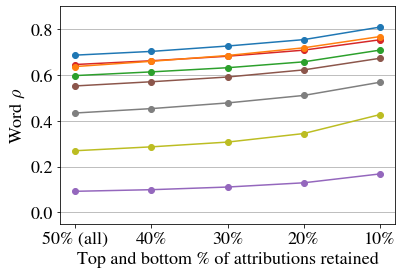

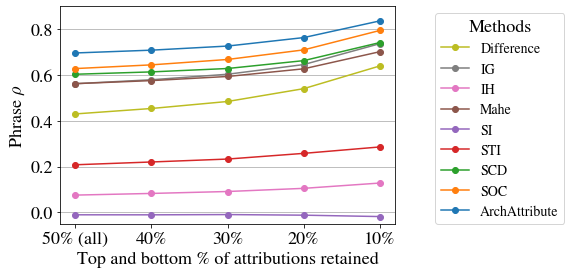

In [4]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for e, exp in enumerate(exp_corrs):
    fig= plt.figure()
    ax = fig.gca()
    for m, method in enumerate(methods):
        if method in exp_corrs[exp]:
            ax.plot(pcts[::-1], exp_corrs[exp][method], marker = 'o', label=method, color=colors[len(methods)-1-m])
            
    
    if e == 1:
        ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=14, title="Methods", title_fontsize=18)
    ax.set_ylim(-0.05, .9)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xticklabels([0, "50% (all)"  , "40%" ,"30%", "20%", "10%"] , fontsize=18)


    if e == 0:
        plt.ylabel(r"Word $\rho$", fontsize=18)
    else:
        plt.ylabel(r"Phrase $\rho$", fontsize=18)

    plt.xlabel("Top and bottom % of attributions retained", fontsize=18)
    ax.yaxis.grid(True)
    
    
    if e == 1:
        plt.savefig("plots/phrase_corr_sweep_" + save_tag + ".pdf", bbox_inches="tight")
    else:
        plt.savefig("plots/word_corr_sweep_" + save_tag + ".pdf", bbox_inches="tight")

    plt.show()

In [5]:
pct_selection = 0.1

for exp in exp_corrs:
    print(exp.encode())
    for method in methods:
        if method not in exp_corrs[exp]:
            print("\t", method, None)
        else:
            print("\t", method, exp_corrs[exp][method][pcts.index(pct_selection)])
            
    print()

b'word $\rho$'
	 Difference 0.42673688858031994
	 IG 0.5681150994907882
	 IH None
	 Mahe 0.6728139190526676
	 SI 0.1676883269064443
	 STI 0.7537163564016338
	 SCD 0.7085688518791841
	 SOC 0.7677269918509788
	 ArchAttribute 0.8091026338253843

b'phrase $\rho$'
	 Difference 0.6394157668962154
	 IG 0.7367396773966026
	 IH 0.1278885181523893
	 Mahe 0.7016773222539894
	 SI -0.018489531912066953
	 STI 0.2856020694670902
	 SCD 0.7416261508301104
	 SOC 0.7944615235459436
	 ArchAttribute 0.8362558065376072

